In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from urllib.parse import urlencode
from urllib.request import Request, urlopen
import json
import numpy as np
import pandas as pd

## Connect to Fakebox API
We use an external library for fake news detection called FakeBox.<br>
Link to library: https://machinebox.io/docs/fakebox

In [2]:
api_url = 'http://localhost:8080/fakebox/check' # Set destination URL here

In [3]:
# Helper functions
def get_json_str(title, content=None, url=None):
    if content and url:
        post_fields = {'title': title, 'content': content, 'url': url}     # Set POST fields here
    elif content:
        post_fields = {'title': title, 'content': content}     # Set POST fields here
    else:
        post_fields = {'title': title}
    request = Request(api_url, urlencode(post_fields).encode())
    json_str = urlopen(request).read().decode()
    return json_str

In [4]:
def parse_json_str(json_str, content=None, url=None):
    json_data = json.loads(json_str)
    title_fake_score = json_data['title']['score']
    title_pred_type = json_data['title']['decision']
    if content:
        content_fake_score = json_data['content']['score']
        content_pred_type = json_data['content']['decision']
    else:
        content_fake_score = 0
        content_pred_type = 0
    if url:
        domain_type = json_data['domain']['category']
    else:
        domain_type = None
    return title_fake_score, title_pred_type, content_fake_score, content_pred_type, domain_type

## Predict on test data
Let's test the accuracy of FakeBox on an independent dataset. <br>
The dataset was retrieved from: https://github.com/GeorgeMcIntire/fake_real_news_dataset

In [5]:
test_df = pd.read_csv('data/real_or_fake.csv', dtype = {'title': str, 'text': str})

In [6]:
print("Number of news articles = {}".format(len(test_df)))

Number of news articles = 6335


In [11]:
# Let's look at the dataset
test_df[['title','text','label']].head(5)

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [12]:
# Select a subset of the dataset
test_df = test_df[:3000]

In [ ]:
# Run Fakebox on dataset
all_title_fake_score = []
all_title_pred_type = []
all_content_fake_score = []
all_content_pred_type = []
i = 0
for index, row in test_df.iterrows():
    content = row['text'][:10000]
    # content = None
    json_str = get_json_str(row['title'], content)
    title_fake_score, title_pred_type, content_fake_score, content_pred_type, _ = parse_json_str(json_str, content)
    all_title_fake_score.append(title_fake_score)
    all_title_pred_type.append(title_pred_type)
    all_content_fake_score.append(content_fake_score)
    all_content_pred_type.append(content_pred_type)
    i += 1
    if i%1000 == 0:
        print("Iteration = ", i)

In [16]:
test_df['title_fake_score'] = all_title_fake_score
test_df['title_pred_type'] = all_title_pred_type
test_df['content_fake_score'] = all_content_fake_score
test_df['content_pred_type'] = all_content_pred_type

In [17]:
test_df.to_csv('data/real_or_fake_labelled.csv')

## Classification using Kernel SVM 
Using the title and content fake score, we train a Kernel SVM to perform fake news classification.

In [18]:
X = np.zeros((len(test_df),2))
X[:,0] = test_df['title_fake_score'].values
X[:,1] = test_df['content_fake_score'].values

In [19]:
y = np.ones((len(test_df),)) 
for i, label in enumerate(test_df['label']):
    if label == 'FAKE':
        y[i] = -1

In [20]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [21]:
clf = SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
# Perform k fold cross validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf, X, y, cv=10)
print("10 fold cv score = {}".format(np.average(cv_scores)))

10 fold cv score = 0.623660233261851


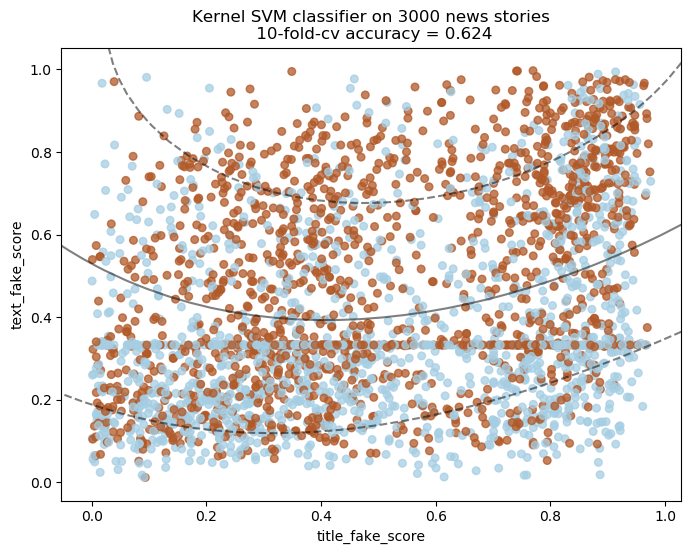

In [28]:
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired, alpha=0.75)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none')
plt.xlabel('title_fake_score')
plt.ylabel('text_fake_score')
plt.title('Kernel SVM classifier on {} news stories\n 10-fold-cv accuracy = {:.3f}'.format(X.shape[0], np.average(cv_scores)))
plt.show()

## Organised articles by difficulty

In [5]:
import news_generator as news

In [6]:
df = news.get_news_df('data/filtered_fake_labelled.csv')
df['difficulty'] = 1 - df['content_fake_score']

Text(0.5,1,'Scored Fake News')

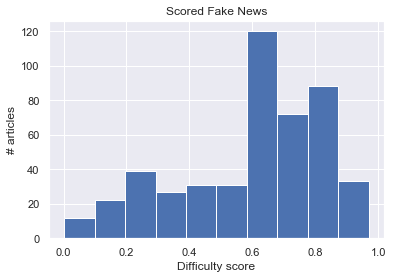

In [18]:
ax = plt.hist(df['difficulty'])
plt.xlabel('Difficulty score')
plt.ylabel('# articles')
plt.title('Scored Fake News')

In [43]:
# Hard articles
for _ in range(5):
    article = news.get_random_article_by_difficulty(df, 'hard')
    print(article['title'])

Doug Casey: A Civil War Could Be in the Cards After the Election
Heartless Trump cuts sweet old grannys water supply
Can normal transistors act like a qubit?
DONALD J. TRUMP - Officially Lays Out His NEW DEAL FOR BLACK AMERICA.
Doug Casey: A Civil War Could Be in the Cards After the Election


In [44]:
# Easy articles
for _ in range(5):
    article = news.get_random_article_by_difficulty(df, 'easy')
    print(article['title'])

ISIS update 10/26/2016..Aircraft Carrier "Admiral Kuznetsov" enters Strait Of Gibraltar | Politics
Kremlin: NATO was Created for Agression
S Korea coast guard opens fire on China boats
Putin grants Steven Seagal Russian citizenship
Russia: Rebel Attacks Around Aleppo Jeopardize Pause in Airstrikes
